# Clean that twitter data!

Use of the "Table of Contents" nbextension is highly recommended.

### Basic imports, settings

In [3]:
import sys
sys.path.append('/home/tandemelephant/anaconda3/envs/graph-tool/lib/python3.7/site-packages')

import numpy as np
import pandas as pd
import re
import nltk
import os
import json
import matplotlib.pyplot as plt
from copy import deepcopy

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth',100)

## Read data

In [4]:
dir_path = '../data/tweets_maga'
data_original = pd.DataFrame()

print('Loading tweets from', dir_path)
file_names = [file for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))]
for file_name in file_names:
    
    if not re.match(r'tweets_', file_name):
        continue
        
    file_path = dir_path + '/' + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        tweets = pd.read_json(file)
        data_original = pd.concat([data_original, tweets], ignore_index=True)
        
print('Successfully loaded {} tweets from {} files.'.format(len(data_original), len(file_names)))

Loading tweets from ../data/tweets_maga
Successfully loaded 50000 tweets from 54 files.


In [7]:
data_original.text.str.len().mean()

182.48442

In [23]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
tokens = data_original.text.apply(lambda text: tokenizer.tokenize(re.sub(r'[^\w]', ' ', 
                                                                  re.sub(r'http(\S)*', '', 
                                                                  re.sub(r'@\S*', '', 
                                                                  re.sub(r'#\S*', '', text))))))

In [16]:
tokens

0        [realDonaldTrump, I, m, confused, Is, this, a, new, greatest, or, the, same, as, the, old, All, ...
1                      [realDonaldTrump, Hyundai, Kia, Aptiv, I, m, not, yet, tired, of, winning, Sir, MAGA]
2        [WA_Silenced_Maj, realDonaldTrump, You, are, the, true, patriots, If, Antifa, physically, assaul...
3        [It, is, amazing, to, watch, RudyGiuliani, throw, his, reputation, down, the, toilet, My, guess,...
4                     [w_terrence, realDonaldTrump, WHOOOHOOO, I, m, so, excited, for, you, MAGA, KAG, 2020]
5        [Trump, LIED, ABOUT, WIKILEAKS, in, MuellerReport, The, grand, jury, REDACTIONS, in, special, co...
6                      [Never, polled, and, don, t, know, anyone, that, has, MAGA, https, t, co, n1bzaxntWX]
7        [GettumGirl, Maga, needs, to, get, off, their, ass, and, put, their, foot, down, Dems, Antifa, s...
8                                                                    [realDonaldTrump, Beautiful, KAG, MAGA]
9        [RedOctobe

In [24]:
tokens.str.len().max()

72

## Clean data

In [9]:
from nltk import edit_distance
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tandemelephant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tandemelephant/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [13]:
STOP_WORDS = set(stopwords.words('english'))
STEMMER = SnowballStemmer('english')
LEMMATIZER = WordNetLemmatizer()
EXCLUDE_TOKENS = set(['amp'])

def lemmatize_stem(word):
    return STEMMER.stem(LEMMATIZER.lemmatize(word, pos='v'))

def preprocess_text(text):
    
    # everything in lower case, strip
    text = text.lower().strip()
    
    # remove every #tag, @username, links
    text = re.sub(r'http(\S)*', '', re.sub(r'@\S*', '', re.sub(r'#\S*', '', text)))
    # replace every non alphanumeric character with whitespace
    text = re.sub(r'[^\w]', ' ', text)
    
    # tokenize
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text)
    
    
    # remove words with length < 3, or starting with non alphanumeric characters
    # remove stopwords
    
    pattern = re.compile('\w\w\w+')
    tokens = list(filter(pattern.match, [t for t in tokens if t not in STOP_WORDS]))
    
    # lemmatize and stem
    tokens = [lemmatize_stem(t) for t in tokens]
    
    #custom filters
    return [t for t in tokens if t not in EXCLUDE_TOKENS]

In [14]:
data = deepcopy(data_original)
# data = deepcopy(data_original[(original_text.str.lower().str.find('#brexit') > -1)])
data['tokens'] = data.text.apply(preprocess_text)
data[['text','tokens']]

text  \
0      @realDonaldTrump I’m confused. Is this a new “greatest” or the same as the old? All of your scan...   
1                          @realDonaldTrump @Hyundai @Kia @Aptiv I'm not yet tired of winning, Sir!  #MAGA   
2      @WA_Silenced_Maj @realDonaldTrump You are the true patriots!  If Antifa physically assaults you ...   
3      It is amazing to watch @RudyGiuliani throw his reputation down the toilet. My guess @realDonaldT...   
4                   @w_terrence @realDonaldTrump WHOOOOOHOOOOO! I’m so excited for you! #MAGA #KAG2020♥️🇺🇸   
...                                                                                                    ...   
49995  The @GOP has blood on their hands.\n#MAGA supporters have blood on their hands. https://t.co/Kvm...   
49996  @DeepStateExpose @realDonaldTrump Um... it’s a joke.\nChristian Kurds are being killed because o...   
49997  #Benghazi #MAGA #WWG1WGA #GreatAwakening #DarkToLight #TraitorsJustice and EQUAL #JusticeForAll ...   
49998  @MarkRuffalo To get back at Iran for the humiliation of the hostage crisis, in the waning days o...   
49999  @RicciGeri @rickahyatt They don't have to turn it Blue.\nThey just have to put in Vote Machines ...   

                                                                                                 tokens  
0                                       [confus, new, greatest, old, scandal, hard, follow, pussygrabb]  
1                                                                                 [yet, tire, win, sir]  
2                                          [true, patriot, antifa, physic, assault, way, legal, defend]  
3                [amaz, watch, throw, reput, toilet, guess, someth, mayb, bumbl, old, fool, hard, tell]  
4                                                                                    [whooohooo, excit]  
...                                                                                                 ...  
49995                                                               [blood, hand, support, blood, hand]  
49996                                          [joke, christian, kurd, kill, trump, joke, impeach, con]  
49997                                                                                     [equal, late]  
49998  [get, back, iran, humili, hostag, crisi, wan, day, carter, administr, bush, fault, mark, realli]  
49999                                           [turn, blue, put, vote, machin, own, soro, count, vote]  

[50000 rows x 2 columns]

### (optional) Remove duplicates (by token) 

In [15]:
# # remove duplicates
# no_duplicate_ids = data.text.str.replace(r'http(\S)*', ''
#                            ).str.replace(r'@\S*', ''
#                            ).str.replace(r'#\S*', ''
#                            ).drop_duplicates().index

# remove duplicates
no_duplicate_ids = data.tokens.str.join('').drop_duplicates().index

data = data.loc[no_duplicate_ids]
print(f'Dropped {len(data_original) - len(no_duplicate_ids)} duplicates.')
print(f'Data has {len(data)} rows remaining.')

Dropped 5225 duplicates.
Data has 44775 rows remaining.


## Save data

In [16]:
data.to_csv(dir_path + '/' + 'data_merged.csv')

## Wordcloud

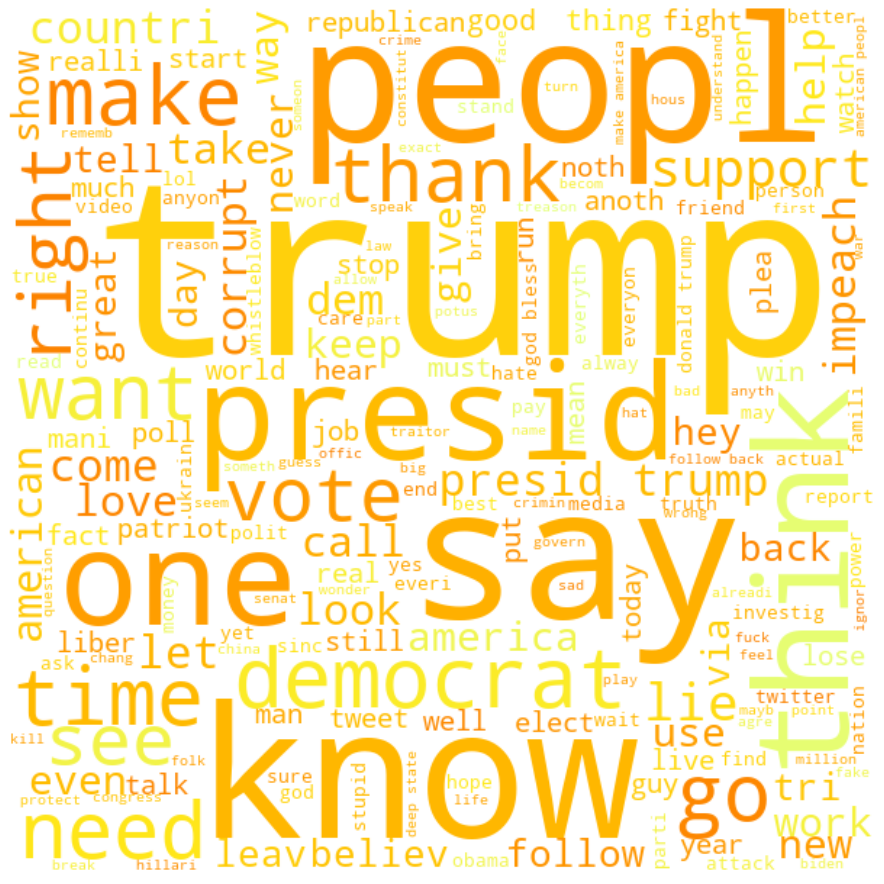

In [27]:
from wordcloud import WordCloud
all_words = [word for sublist in data.tokens.values for word in sublist ]
word_cloud = WordCloud(width = 600, height=600, background_color='white', colormap='Wistia').generate(' '.join(all_words))

fig, ax = plt.subplots(figsize=(16,16))

ax.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.savefig('../img/maga_cloud.png', facecolor='white')
plt.show()